# Imports

In [1]:
from tqdm.notebook import tqdm

In [94]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import seqeval.metrics

from transformers import AutoTokenizer

In [2]:
## create dummy data 

In [39]:
labels = {
    'B-First':0,
    'I-First':1,
    'B-Second':2,
    'I-Second':3,
    'O':4,
    'PAD':-100
}

reversed_labels={v:k for k,v in labels.items()}

y_true = np.array([[0,1,1,1,4,2,3,3,3,-100,-100,-100],[-100,0,1,4,4,2,3,3,3,0,1,-100]])
y_pred = np.array([[0,1,1,1,4,2,3,3,4,4,4,4],[-100,0,1,1,2,2,3,3,0,0,0,4]])

# Accuracy

## seqeval experimentation

In [19]:
seqeval.metrics.accuracy_score(y_true,y_pred)

array([1. , 1. , 1. , 0.5, 0. , 1. , 1. , 1. , 0. , 0.5, 0. , 0. ])

In [54]:
def labeling_without_pad(y_true,y_pred,padding=-100):
    
    labels = {
    'B-First':0,
    'I-First':1,
    'B-Second':2,
    'I-Second':3,
    'O':4,
    'PAD':padding
    }

    reversed_labels={v:k for k,v in labels.items()}

    try:
        if not isinstance(y_true,numpy.array):
            y_true = y_true.numpy()
        if not isinstance(y_pred,numpy.array):
            y_pred = y_pred.numpy()
    except:
        "must be passed TF or NP"
    
    
    batch_size,seq_len = y_pred.shape
    labels, preds = [],[]
    
    for i in range(batch_size):
        labels_ , preds_ = [], []
        for j in range(seq_len):
            if y_true[i][j] !=-100:
                labels_.append(reversed_labels[y_true[i][j]])
                preds_.append(reversed_labels[y_pred[i][j]])
        labels.append(labels_)
        preds.append(preds_)
        
    return preds,labels
        

In [55]:
preds,labels=labeling_without_pad(y_true,y_pred)
print(seqeval.metrics.classification_report(preds,labels))

              precision    recall  f1-score   support

       First       0.33      0.20      0.25         5
      Second       0.00      0.00      0.00         3

   micro avg       0.20      0.12      0.15         8
   macro avg       0.17      0.10      0.12         8
weighted avg       0.21      0.12      0.16         8



In [56]:
seqeval.metrics.f1_score(labels,preds)

0.15384615384615385

In [75]:
seqeval.metrics.accuracy_score(labels,preds)

0.7368421052631579

## Accuracy masked subclassing

In [204]:
class AccuracyMasked(tf.keras.metrics.Metric):
    
    def __init__(self,class_to_ignore,name='accuracy_masked',**kwargs):
        super().__init__(name=name,**kwargs),
        self.class_to_ignore = class_to_ignore
        self.accs = self.add_weight(name = 'accs',initializer = 'zeros',dtype='float64')        
    
    def update_state(self,y_true,y_pred):
        #y_pred = tf.argmax(y_pred,axis=-1)
        #y_true = tf.argmax(y_true,axis=-1)#for y_pred and y_true to match
        #mask = tf.cast(tf.not_equal(y_true,self.class_to_ignore),'int32') #create a mask
        #matches = tf.cast(tf.equal(y_true,y_pred),'int32')*mask #calculate the matches ignoring the masking
        #accuracy = tf.math.reduce_sum(matches,axis=-1)/tf.maximum(tf.math.reduce_sum(mask,axis=-1),1)
        accuracy=tf.math.reduce_sum(tf.cast(y_true == y_pred,'int32')*tf.cast(y_true != -100,'int32'))/tf.math.reduce_sum(tf.cast(y_true != -100,'int32'))
        self.accs.assign_add(tf.math.reduce_mean(accuracy))
        
    
    def result(self):
        return self.accs #tf.math.reduce_mean(accuracy)


In [205]:
accuracymasked = AccuracyMasked(-100)

accuracymasked(y_pred,y_true)

<tf.Tensor: shape=(), dtype=float64, numpy=0.6086956521739131>

In [181]:
tf.math.reduce_sum(tf.cast(y_true == y_pred,'int32')*tf.cast(y_true != -100,'int32'))/tf.math.reduce_sum(tf.cast(y_true != -100,'int32'))

<tf.Tensor: shape=(), dtype=float64, numpy=0.7368421052631579>

In [99]:
mask = tf.cast(tf.not_equal(y_true,-100),'int32') #create a mask
matches = tf.cast(tf.equal(y_true,y_pred),'int32')*mask #calculate the matches ignoring the masking
accuracy = tf.math.reduce_sum(matches,axis=-1)/tf.maximum(tf.math.reduce_sum(mask,axis=-1),1)

In [103]:
tf.math.reduce_mean(accuracy)

<tf.Tensor: shape=(), dtype=float64, numpy=0.7444444444444445>

## Accuracy homemade via function

In [208]:
##SIMPLER ACCURACY definition

def accuracy_masked_func(y_true,y_pred):
    #y_pred = tf.argmax(y_pred,axis=-1)
    #y_true = tf.argmax(y_true,axis=-1)#for y_pred and y_true to match
    mask = tf.cast(y_true != -100,'int32') #create a mask
    matches = tf.cast(tf.equal(y_true,y_pred),'int32')*mask #calculate the matches ignoring the masking
    accuracy = tf.math.reduce_sum(matches,axis=-1)/tf.maximum(tf.math.reduce_sum(mask,axis=-1),1)
    
    return accuracy

In [207]:
accuracy_masked_func(y_true,y_pred)

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.88888889, 0.6       ])>

In [210]:
accuracy_masked = tf.keras.metrics.MeanMetricWrapper(fn=accuracy_masked_func)

In [211]:
accuracy_masked(y_true,y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7444445>

# Evaluation metric

In [ ]:
## Pseudo code

# 1- calculate the overlaps
# 2- for each pred : determine if it is a TP/FN/TN regarding the opvermap 
# 3- compute f1 score for each class 
# 4- compute f1 macro score across all classes 

In [3]:
df_essays = pd.read_csv('../raw_data/preprocessed.csv')
#df = pd.read_csv('../raw_data/train.csv')

## Get preds

In [4]:
import pickle

In [5]:
with open('../raw_data/train_v2.pickle','rb') as file : 
    train = pickle.load(file)
with open('../raw_data/val_v2.pickle','rb') as file : 
    val = pickle.load(file)
with open('../raw_data/test_v2.pickle','rb') as file : 
    test = pickle.load(file)
with open('../raw_data/test_pred.pickle','rb') as file : 
    test_pred = pickle.load(file)
    
y_pred = np.argmax(test_pred,axis=-1)
y_true = np.argmax(test[1],axis=-1)

In [6]:
#compute the index for each split of the dataset (at essay level)
idx_train = range(0,len(train[1]))
idx_val = range(len(train[1]),len(train[1])+len(val[1]))
idx_test = range(len(train[1])+len(val[1]),len(train[1])+len(val[1])+len(test[1]))

In [7]:
#store the list of all the essays ids for test split
essay_ids = df_essays.loc[idx_test].id.values

In [8]:
df_essays.loc[df_essays.id.isin(essay_ids)]

,id,predictionstring,label,essays
14034,E6870101D8EE,"['0', '1', '2', '3', '4', '5', '6', '7', '8', ...","['B-Evidence', 'I-Evidence', 'I-Evidence', 'I-...",Car usage in the United States has gone down b...
14035,E68CDA395B2D,"['0', '1', '2', '3', '4', '5', '6', '7', '8', ...","['B-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Le...","Often times, when we're looking for advice we ..."
14036,E6A0EF9688EE,"['0', '1', '2', '3', '4', '5', '6', '7', '8', ...","['B-Position', 'I-Position', 'I-Position', 'I-...","I agree, students should participate in after ..."
14037,E6ABFC76F25E,"['0', '1', '2', '3', '4', '5', '6', '7', '8', ...","['B-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Le...",Have you ever thought about participating in a...
14038,E6B00E088C29,"['0', '1', '2', '3', '4', '5', '6', '7', '8', ...","['B-Position', 'I-Position', 'I-Position', 'I-...",In the article the author greatly supports the...
...,...,...,...,...
15589,FFF1442D6698,"['0', '1', '2', '3', '4', '5', '6', '7', '8', ...","['B-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Le...","Every student looks forward to summer break, i..."
15590,FFF1ED4F8544,"['0', '1', '2', '3', '4', '5', '6', '7', '8', ...","['B-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Le...",Many citizens argue that the Electoral college...
15591,FFF868E06176,"['0', '1', '2', '3', '4', '5', '6', '7', '8', ...","['B-Lead', 'I-Lead', 'I-Lead', 'I-Lead', 'I-Le...","Every summer break, students are given project..."
15592,FFFD0AF13501,"['44', '45', '46', '47', '48', '49', '50', '51...","['B-Claim', 'I-Claim', 'I-Claim', 'I-Claim', '...","In the article ""A Cowboy Who Rode the Waves"" L..."


In [9]:
labels_mapping = {'B-Lead' : 0,
                  'B-Position' : 1,
                  'B-Evidence' : 2,
                  'B-Claim' : 3,
                  'B-Concluding_Statement' : 4,
                  'B-Counterclaim' : 5,
                  'B-Rebuttal' : 6,
                  'I-Lead' : 7,
                  'I-Position' : 8,
                  'I-Evidence' : 9,
                  'I-Claim' : 10,
                  'I-Concluding_Statement' : 11,
                  'I-Counterclaim' : 12,
                  'I-Rebuttal': 13,
                 'O':14,
                 'PAD':15}

reversed_mapping = {v:(k[2:] if v<14 else k) for k,v in labels_mapping.items()}

In [10]:
def get_preds_v2(seq,word_ids):
    
    labels = []
    predictionstrings = []
    counts = []
    
    counter=dict()
    
    for tok,pos in zip(seq,word_ids):
        
        if tok <= 13:
            lab = reversed_mapping[tok]
            labels.append(lab)
            predictionstrings.append(pos)
            if len(labels)<2:
                counts.append(str(1))
                counter.setdefault(lab,1)
                continue
            if lab == labels[-2]:
                counts.append(str(counter[lab]))
            else: 
                try:
                    counter[lab]+=1
                except KeyError:
                    counter.setdefault(lab,1)
                counts.append(str(counter[lab]))
    
    preds = pd.DataFrame([labels,counts,predictionstrings],index=['class','count','predictionstring']).T
    preds['class'] += ' ' + preds['count'].astype(str)
    preds = preds.groupby('class',sort=False).agg({'predictionstring':list}).reset_index()
    preds['class']=preds['class'].apply(lambda txt : txt.split()[0])
    preds['predictionstring']=preds['predictionstring'].apply(lambda l_ : [str(l) for l in l_])
    preds['predictionstring']=preds['predictionstring'].apply(lambda l_ : ' '.join(l_))
    
    return preds

In [11]:
get_preds_v2(y_pred[-2],test[2][-2])

,class,predictionstring
0,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,Position,35 36
2,Claim,40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 5...
3,Evidence,57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 7...
4,Claim,107 108 109 110 111 112 113 114 115 116 117 11...
5,Evidence,120 121 122 123 124 125 126 127 128 129 130 13...
6,Concluding_Statement,191 192 193 194 195 196 197 198 199 200 201 20...


In [12]:
def true_positive(predictionstring_true,predictionstring_pred):
    ps_true = set(predictionstring_true.split(' '))
    ps_pred = set(predictionstring_pred.split(' '))
    
    inter = ps_pred.intersection(ps_true)
    overlap_1 = len(inter)/len(ps_true)
    overlap_2 = len(inter)/len(ps_pred)
    
    if overlap_1 >= .5 and overlap_2 >= .5:
        return 1
    return 0


In [13]:
## vectorize the funct
true_positive_vect = np.vectorize(true_positive)

In [14]:
## get two examples
true_df = get_preds_v2(y_true[43],test[2][43])
pred_df = get_preds_v2(y_pred[43],test[2][43])

In [15]:
## create a df joined to get all possibilities with outer join
joined = pred_df.merge(true_df,how = 'outer',on='class',suffixes=('_pred','_true'))

In [16]:
## if a pred is not matched it is a FN ; if the truth is not matched it is a FP

#creating separate columns 
joined['FP'] = np.where(joined.predictionstring_true == np.nan, 1, 0)
joined['FN'] = np.where(joined.predictionstring_pred == np.nan, 1, 0)


#cleaning nan for the true positive function
joined['predictionstring_pred'].fillna('',inplace=True)
joined['predictionstring_true'].fillna('',inplace=True)



## On test split 

In [22]:
## Create two DF with preds and ground truth

##TODO refactor to function

y_true = np.argmax(test[1],axis=-1)
y_pred = np.argmax(test_pred,axis=-1)

tok_pos = test[2]

true_df = pd.DataFrame()
pred_df = pd.DataFrame()

for i,idx in tqdm(enumerate(idx_test),desc='youhou',total=len(idx_test)): ## CHANGE idx_test
    
    true_ = get_preds_v2(y_true[i],tok_pos[i])
    pred_ = get_preds_v2(y_pred[i],tok_pos[i])
    
    true_['id']=df_essays.iloc[idx]['id']
    pred_['id']=df_essays.iloc[idx]['id']
    
    true_df = true_df.append(true_)
    pred_df = pred_df.append(pred_)
    
true_df['unique_id'] = pd.util.hash_pandas_object(true_df,hash_key='1234567890123456')
pred_df['unique_id'] = pd.util.hash_pandas_object(pred_df,hash_key='azerty1234567890')
    

youhou:   0%|          | 0/1560 [00:00<?, ?it/s]

In [276]:
def true_positive(predictionstring_true,predictionstring_pred):
    ps_true = set(predictionstring_true.split(' '))
    ps_pred = set(predictionstring_pred.split(' '))
    
    inter = ps_pred.intersection(ps_true)
    overlap_1 = len(inter)/len(ps_true)
    overlap_2 = len(inter)/len(ps_pred)
    
    if overlap_1 >= .5 and overlap_2 >= .5:
        return 1
    return 0

## vectorize the funct
true_positive_vect = np.vectorize(true_positive)


In [23]:
## Merge the 2 DF to compute F1 

merged_df = pred_df.merge(true_df,how = 'outer',on=['id','class'],suffixes=('_pred','_true'))

## if a pred is not matched it is a FN ; if the truth is not matched it is a FP

#creating separate columns 
merged_df['FP'] = np.where(merged_df.predictionstring_true.isna(), 1, 0)
merged_df['FN'] = np.where(merged_df.predictionstring_pred.isna(), 1, 0)


#cleaning nan for the true positive function
merged_df['predictionstring_pred'].fillna('',inplace=True)
merged_df['predictionstring_true'].fillna('',inplace=True)


merged_df['TP'] = true_positive_vect(merged_df['predictionstring_true'],merged_df['predictionstring_pred'])

merged_df.head()

,class,predictionstring_pred,id,predictionstring_true,FP,FN,TP
0,Lead,0,E6870101D8EE,,1,0,0
1,Lead,8 9,E6870101D8EE,,1,0,0
2,Position,1 2 3 4 5 6 7,E6870101D8EE,86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101,0,0,0
3,Evidence,10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 2...,E6870101D8EE,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,0,0,0
4,Evidence,10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 2...,E6870101D8EE,110 111 112 113 114 115 116 117 118 119 120 12...,0,0,0


In [210]:
## creating f1 function
def f1_score(fp,fn,tp):
    return tp/(tp+.5*(fp+fn))*100

In [227]:
## group by class for F1 score calculation
f1_df = merged_df.groupby('class').sum()

#apply to the df
f1_df['f1']=f1_score(f1_df.FP,f1_df.FN,f1_df.TP)

#Create a total row
f1_df.loc['Total']=f1_df.mean()

In [228]:
## weighted average

f1_df['support'] = true_df.groupby('class').count()['id']

f1_df['f1_weighted']=f1_df['f1']*(f1_df['support']/f1_df['support'].sum())
f1_df.loc['Total','support']=f1_df.support.sum()
f1_df.loc['Total','f1_weighted']=f1_df.f1_weighted.sum()

In [229]:
# impute correct values for the Total row for TP FN FP 

f1_df.loc['Total','FP'] = f1_df.loc[:'Rebuttal','FP'].sum()
f1_df.loc['Total','FN'] = f1_df.loc[:'Rebuttal','FN'].sum()
f1_df.loc['Total','TP'] = f1_df.loc[:'Rebuttal','TP'].sum()

In [230]:
## PRINT REPORT

print(f"F1 Macro Score = {f1_df.loc['Total','f1']:.2f}%")


print(f"F1 Micro Score = {f1_score(f1_df.loc['Total','FP'],f1_df.loc['Total','FN'],f1_df.loc['Total','TP']):.2f}%")

print(f"F1 Weighted Score = {f1_df.loc['Total','f1_weighted']:.2f}%")


F1 Macro Score = 72.15%
F1 Micro Score = 88.30%
F1 Weighted Score = 88.16%


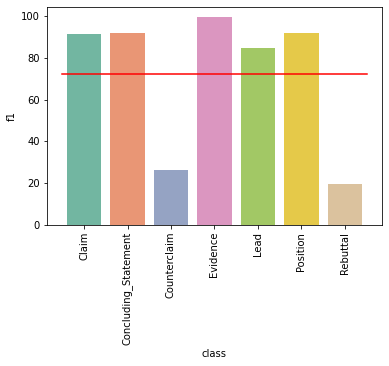

In [231]:
sns.barplot(y=f1_df.reset_index().loc[:6,'f1'],x=f1_df.index[:-1],palette='Set2')
plt.xticks(rotation=90)
locs,_=plt.xticks()
plt.plot([locs[0]-.5,locs[-1]+.5],[f1_df.loc['Total','f1'],f1_df.loc['Total','f1']],c='r');

In [232]:
## Full report
f1_df[['FP','FN','TP','support']]=f1_df[['FP','FN','TP','support']].applymap('{:.0f}'.format)
f1_df['f1_weighted']=f1_df['f1_weighted'].map('{:.2f}%'.format)
f1_df['f1']=f1_df['f1'].map('{:.2f}%'.format)

f1_df

,FP,FN,TP,f1,support,f1_weighted
class,,,,,,
Claim,69,168,1246,91.32%,3412,25.98%
Concluding_Statement,176,17,1086,91.84%,1346,10.31%
Counterclaim,95,307,71,26.10%,542,1.18%
Evidence,23,0,2021,99.43%,3792,31.44%
Lead,195,70,735,84.73%,963,6.80%
Position,6,140,853,92.12%,1535,11.79%
Rebuttal,105,233,41,19.52%,402,0.65%
Total,669,935,6053,72.15%,11992,88.16%


In [268]:
th = pd.util.hash_pandas_object(true_df,hash_key='1234567890123456')
ph = pd.util.hash_pandas_object(pred_df,hash_key='azerty1234567890')

In [269]:
th.append(ph).duplicated().sum()

0

In [271]:
true_df['unique_id'] = pd.util.hash_pandas_object(true_df,hash_key='1234567890123456')
pred_df['unique_id'] = pd.util.hash_pandas_object(pred_df,hash_key='azerty1234567890')
   

,class,predictionstring,id,unique_id
0,Evidence,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,E6870101D8EE,14477218731601924144
1,Position,86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101,E6870101D8EE,5805293810922453719
2,Claim,102 103 104 105 106 107 108 109,E6870101D8EE,7917867347018931750
3,Evidence,110 111 112 113 114 115 116 117 118 119 120 12...,E6870101D8EE,15627381070960190603
4,Claim,216 217 218 219 220 221 222 223 224 225 226,E6870101D8EE,14918917895061095889
...,...,...,...,...
2,Claim,83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 9...,FFFD0AF13501,8568897044738393866
3,Evidence,116 117 118 119 120 121 122 123 124 125 126 12...,FFFD0AF13501,9778262153578950733
4,Position,193 194 195 196 197 198 199 200 201 202 203 20...,FFFD0AF13501,6700318162194262387
5,Concluding_Statement,209 210 211 212 213 214 215 216 217 218 219 22...,FFFD0AF13501,10261607527697011422


In [273]:
merged_df = pred_df.merge(true_df,how = 'outer',on=['id','class'],suffixes=('_pred','_true'))

## if a pred is not matched it is a FN ; if the truth is not matched it is a FP

#creating separate columns 
merged_df['FP'] = np.where(merged_df.predictionstring_true.isna(), 1, 0)
merged_df['FN'] = np.where(merged_df.predictionstring_pred.isna(), 1, 0)


#cleaning nan for the true positive function
merged_df['predictionstring_pred'].fillna('',inplace=True)
merged_df['predictionstring_true'].fillna('',inplace=True)


merged_df['TP'] = true_positive_vect(merged_df['predictionstring_true'],merged_df['predictionstring_pred'])

merged_df.head()

,class,predictionstring_pred,id,unique_id_pred,predictionstring_true,unique_id_true,FP,FN,TP
0,Lead,0,E6870101D8EE,17566675517480382464.00,,NaN,1,0,0
1,Lead,8 9,E6870101D8EE,1194444511410043904.00,,NaN,1,0,0
2,Position,1 2 3 4 5 6 7,E6870101D8EE,3654493487852571648.00,86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101,5805293810922454016.00,0,0,0
3,Evidence,10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 2...,E6870101D8EE,2343163086631562240.00,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,14477218731601924096.00,0,0,0
4,Evidence,10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 2...,E6870101D8EE,2343163086631562240.00,110 111 112 113 114 115 116 117 118 119 120 12...,15627381070960191488.00,0,0,0


In [283]:
merged_df[merged_df['FN']==1]['unique_id_pred'].duplicated().sum()

934

## Confusion matrix

In [284]:
from sklearn.metrics import confusion_matrix

In [420]:
def show_confusion_matrix(y_true,y_pred):

    reversed_mapping = {
                        0: 'Lead',
                        1: 'Position',
                        2: 'Evidence',
                        3: 'Claim',
                        4: 'Concluding_Statement',
                        5: 'Counterclaim',
                        6: 'Rebuttal',
                        7: 'Lead',
                        8: 'Position',
                        9: 'Evidence',
                        10: 'Claim',
                        11: 'Concluding_Statement',
                        12: 'Counterclaim',
                        13: 'Rebuttal',
                        14: 'O',
                        15: 'PAD'}
    
    y_true_flat = [reversed_mapping[y] for y in y_true.flatten()]
    y_pred_flat = [reversed_mapping[y] for y in y_pred.flatten()]
    
    LABELS = ['Lead','Position','Claim','Counterclaim','Rebuttal','Evidence','Concluding_Statement','O','PAD']

    cfn = confusion_matrix(y_true_flat,y_pred_flat,labels=LABELS)
    
    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.title('Confusion Matrix',size=18,pad=20)
    sns.heatmap(cfn/np.sum(cfn,axis=0)*100,cmap='Blues',annot = True,fmt='.2f',annot_kws={'size':10},ax=ax);
    plt.xticks(np.arange(len(LABELS))+.5,LABELS,rotation = 90,size=12);
    plt.yticks(np.arange(len(LABELS))+.5,LABELS,rotation = 0,size=12);
    plt.xlabel('PREDICTED',size=16);
    plt.ylabel('ACTUAL',size=16);
    for t in ax.texts: t.set_text(t.get_text() + " %")
    
    plt.show()

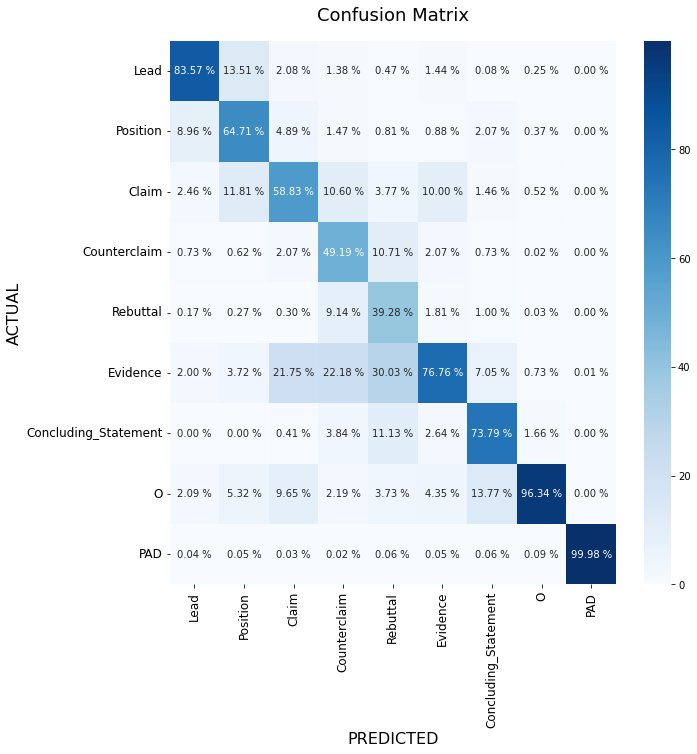

In [421]:
show_confusion_matrix(y_true,y_pred)